# Notebook Overview — Training the Primary Random Forest Model (Based on López de Prado, *AFML*)

This notebook implements the full model-training stage of the research pipeline for cross-sectional U.S. equities, following the event-based methodology outlined by Marcos López de Prado in *Advances in Financial Machine Learning* (2018). Using the aligned feature matrices and primary event labels produced in earlier notebooks, this workflow trains and evaluates a Random Forest model to predict the **direction** of the next volatility-adjusted move identified by the triple-barrier method. To ensure methodological rigor, the notebook first splits the overall Data into Training (Period : 2013/01/01 to 2021/01/01) and Test Set (Period : 2021/04/01 to 2023/21/31) based on dates including purge window, so Test Set is truly Out of Sample. Training is strictly applied only to the Training Set. Purging window is set to 60 Day Window, because in the feature computation the longest historical horizon a feature spans is 60 Days. This Method is used to obtai preventing information leakage across overlapping event horizons and securing an unbiased assessment of predictive performance.

Below, the notebook’s functionality is partitioned into the core components of the modeling pipeline.

**1. Data Loading and Alignment**

The notebook begins by loading the event-filtered dataset, i.e. the preprocessed feature matrices and primary labels produced by earlier stages of the pipeline. This dataset contains the events identified by the Triple Barrier Method, where each event is determined by a stock-specific volatility threshold and therefore represents a major, volatility-adjusted market movement. All features have been winsorized and normalized using the preprocessing procedures, and the primary labels (Side = −1 / 0 / +1) originate directly from the triple-barrier event-labeling notebook.

**2. Cross-Validation Setup: Purged K-Fold (AFML Ch. 7)**

To avoid look-ahead bias—a central concern in financial ML—the notebook implements **purged time-series K-fold cross-validation**, with a purging Window of 60 Days between training and validation folds. This prevents leakage caused by:

* Overlapping event horizons
* Serial dependence
* Information-propagation through near-adjacent timestamps

The Method for Date based purged Cross Validatio is available in the **purged_cv_by_date.py** including an additional method for testing the Cross Validation splits to ensure there is no overlap **test_purged_cv_by_date**.

**3. Hyperparameter Tuning (Primary Model)**

The Notebook includes Hyperparamter Tuning for the Primary Model using the purged Time Series K Fold Cross-Validation. 

**4. Random Forest Training (Primary Model)**

The primary model a **Random Forest classifier** is first trained using the purged purged Time Series K Fold Cross-Validation to produce out of sample prediction of the event-based **Side** label (−1 / 0 / +1) and Probability for each Event in the Training Data set. For each fold, the notebook computes **out-of-fold predictions**, yielding a fully out-of-sample set of side predictions and class probabilities. This is later used for the Meta Labeling Procedure. The model is trained independently on each purged fold using only features available up to each event timestamp. This stage focuses **only on the primary directional prediction**, not meta-labeling.

This provides a realistic assessment of the model’s directional edge—typically modest in financial time series, but essential for signal construction.

In the next step the Primary Model is trained on the Full Dataset using the Hyperparameter obtained from Hyperparameter Tuning. This Model is used for further predicitons on the Test Set.

**5. Meta Labeling based on (based on López de Prado, AFML)**

In the next Step meta-labeling is implemented on the Training Set, one of the key innovations introduced by López de Prado. The idea is that the primary model only needs to predict the side of the trade (long/short), not whether the trade should be taken. A second model—the meta-model—learns to predict whether the primary model’s signal is likely to be correct. This step transforms raw directional predictions into a selective, risk-adjusted trading rule: the primary model predicts direction; the meta-model predicts whether to act on it.

In the current implementation the Meta Label is assigned a Value of 1 if the predicted Side of the Primary Model is equal to the correctly determined Side (based on Return at Event End Time) and the prediction probability of the Side of the primary Model is greater then a predifined threshold. This is currently set to 0.45. Given that Label distribution is approximately 1/3. this corresponds to a prediction probability slightly above chance.


**5. Secondary Model (Random Forest)**

The Labeled Dataset at this stage contains the following Label information:
* From the primary Model: Side, predicted Side, predicited Side probability. 
* From the secondary Model: predicted Label (1/0 based on correct Side predictio and probability threshold) and predicted Label Probabilty.
Then the Meta Model (also Random Forest) is trained on that Dataset including hte predicted side and prediction Probability for the Side as Features, to determine the Label of the Event. A Label of 1 corresponds to the unfiltered Trade Signal and 0 to the unfiltered No Trade Signal. The final Strategy later uses an additional Threshold on the Label Prediction Probabilty to determine which of the Trade signals to trust (set to 0.7).


**6. Strategy Evaluation on the Test Set**
Then the Pipeline is applied to the unseen Test Set. Meaning first predicting using the primary Model the Side of the Trade. Then based on predicted Side and probability use the secondary Model (Meta Model) to predict the Label for each Event in the Test Dataset. Finally based on the predicted Signal the resulting Strategy is tested using the Metrics: Ratio of filtered trades to Total number of unfiltered Trades, the Mean event return, Mean daily event return, Std of daily event return and finally the annualized Sharpe Ratio.

## Strategy Definition

**Side Labeling (Primary Labels)**

Directional labels are created using the **Triple Barrier Method** applied to each stock in the cross-sectional CRSP universe. Events are defined and labeled as follows:
* **Profit-Taking (PT) and Stop-Loss (SL) Barriers:**
  Barriers are placed at distances proportional to the stock-specific **Base Width**, computed as Base Width = 1.5 * daily volatility.
  A barrier factor of **1.0** is applied to both PT and SL.

* **Vertical Barrier:**
  A maximum holding period of **20 trading days** is enforced, ensuring that each event has a finite time horizon.

* **Minimum Return Threshold:**
  If the realized return at the event’s End Time is less than **±2%**, the event is labeled as **0**, representing no economically meaningful movement.

This procedure produces a **balanced 3-class labeling scheme** (−1, 0, +1) that focuses the model on major volatility-adjusted price moves while filtering out noise.

**2. Meta Labeling (Secondary Labels)**

The meta-label evaluates the **reliability of the primary model’s prediction**:

* A meta-label of **1** is assigned if the primary model’s predicted side matches the realized side of the event (i.e., if the model was correct).
* A meta-label of **0** is assigned otherwise.

To incorporate classifier confidence:

* If the primary model predicts the correct direction with a probability **below 0.45**, the meta-label is automatically set to **0**.

This stage converts raw directional predictions into a **decision-quality signal**, identifying when the primary model’s output is trustworthy enough to trade.

**3. Trading Rule**

Trades are executed only under **high-confidence conditions**:

* A trade is opened **only when the meta-model predicts meta-label = 1 with a probability ≥ 0.7**.

This ensures that the trading strategy acts exclusively on signals with strong statistical backing, significantly reducing noise and improving the robustness of the final portfolio decisions.

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from Labeling import *
from purged_cv_by_date import *

## Extract Trading Dates and Prices

In [2]:
with open("./Data/stocks.pkl", "rb") as file: 
    stocks = pkl.load(file)

In [3]:
prices = stocks[["PERMNO", "Date", "DlyClose"]]

In [4]:
prices = prices.set_index(["Date", "PERMNO"], drop=True)
prices = prices.loc[~prices.index.duplicated(keep='first'), :]

In [5]:
prices

,,DlyClose
Date,PERMNO,
2013-01-02,10026,64.3200
2013-01-03,10026,64.6800
2013-01-04,10026,64.7700
2013-01-07,10026,63.4007
2013-01-08,10026,63.4300
...,...,...
2023-12-22,93429,175.5300
2023-12-26,93429,173.6900
2023-12-27,93429,175.6100


## Read in Side-labeled Data

In [6]:
with open("./Data/feature_scores_events.pkl", "rb") as file:
    data = pkl.load(file)

In [7]:
data.describe()

,Date,PERMNO,ma_5,ema_5,slope_ma_5,ma_10,ema_10,slope_ma_10,ma_20,ema_20,...,pv_corr,pv_divergence,label,DlyClose,timestamp,End Time,Return,trade_days,Return_dly,Side
count,688224,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,...,688224.000000,688224.000000,688224.000000,688224.000000,688224,688224,688224.000000,688224.000000,688224.000000,688224.000000
mean,2018-08-07 20:21:03.063188480,66195.741782,0.006251,0.006304,0.007949,0.006261,0.006244,-0.002353,0.006197,0.006096,...,0.003224,-0.003224,0.002897,57.610769,2018-08-07 20:21:03.063188480,2018-08-12 07:04:26.522527744,0.002202,4.059103,0.000593,0.012258
min,2013-04-04 00:00:00,10026.000000,-1.025310,-1.025152,-7.088935,-1.024847,-1.024539,-6.734629,-1.024029,-1.022825,...,-2.491097,-3.332061,-0.950092,0.040600,2013-04-04 00:00:00,2013-04-05 00:00:00,-0.903307,2.000000,-0.400972,-1.000000
25%,2015-11-24 00:00:00,38093.000000,-0.619627,-0.619671,-0.387763,-0.619814,-0.619955,-0.377465,-0.620055,-0.620458,...,-0.754614,-0.732845,-0.022691,13.020000,2015-11-24 00:00:00,2015-12-02 00:00:00,-0.025090,2.000000,-0.007515,-1.000000
50%,2018-08-14 00:00:00,81621.000000,-0.317590,-0.317421,-0.013043,-0.317315,-0.317345,-0.027073,-0.316977,-0.317004,...,-0.026778,0.026778,0.001392,31.920000,2018-08-14 00:00:00,2018-08-17 00:00:00,0.007318,3.000000,0.001453,0.000000
75%,2021-05-11 00:00:00,89708.000000,0.260188,0.260132,0.387345,0.260470,0.260658,0.355186,0.261000,0.260913,...,0.732845,0.754614,0.024631,66.670000,2021-05-11 00:00:00,2021-05-13 00:00:00,0.025641,5.000000,0.007610,1.000000
max,2023-12-01 00:00:00,93429.000000,6.124177,6.118742,6.570649,6.104151,6.095153,6.785469,6.084156,6.061786,...,3.332061,2.491097,208.852217,3696.060000,2023-12-01 00:00:00,2023-12-21 00:00:00,103.187192,16.000000,20.637438,1.000000
std,NaN,30127.982968,1.002969,1.003000,1.089839,1.002969,1.002965,1.028496,1.002867,1.002767,...,1.012377,1.012377,0.319197,110.095093,NaN,NaN,0.169074,2.569951,0.049418,0.804423


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688224 entries, 0 to 688223
Data columns (total 58 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                688224 non-null  datetime64[ns]
 1   PERMNO              688224 non-null  int64         
 2   ma_5                688224 non-null  float64       
 3   ema_5               688224 non-null  float64       
 4   slope_ma_5          688224 non-null  float64       
 5   ma_10               688224 non-null  float64       
 6   ema_10              688224 non-null  float64       
 7   slope_ma_10         688224 non-null  float64       
 8   ma_20               688224 non-null  float64       
 9   ema_20              688224 non-null  float64       
 10  slope_ma_20         688224 non-null  float64       
 11  ma_60               688224 non-null  float64       
 12  ema_60              688224 non-null  float64       
 13  slope_ma_60         688224 no

In [9]:
data.columns

Index(['Date', 'PERMNO', 'ma_5', 'ema_5', 'slope_ma_5', 'ma_10', 'ema_10',
       'slope_ma_10', 'ma_20', 'ema_20', 'slope_ma_20', 'ma_60', 'ema_60',
       'slope_ma_60', 'ret_1', 'ret_5', 'ret_10', 'ret_20', 'macd_dif',
       'macd_dea', 'macd', 'macd_cross', 'bb_mid', 'bb_upper', 'bb_lower',
       'bb_pctB', 'rsi', 'rsv_10', 'rsv_20', 'aroon_up_10', 'aroon_down_10',
       'aroon_up_20', 'aroon_down_20', 'range_hl_over_c', 'atr', 'gap_oc_prev',
       'gap_cc_prev', 'shadow_upper_ratio', 'shadow_lower_ratio', 'ret_c2c',
       'ret_co', 'ret_oc', 'vol', 'adv', 'dvol', 'vol_z', 'turnover_proxy',
       'vwap_proxy', 'pv_corr', 'pv_divergence', 'label', 'DlyClose',
       'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side'],
      dtype='object')

In [10]:
data["Side"].value_counts()

Side
 0.0    242774
 1.0    226943
-1.0    218507
Name: count, dtype: int64

## 1.1 Hyperparameter Tuning for Random Forest using Smaller Time Period

In [17]:
data_cv = data[(data["Date"]>= "2016-01-01") & (data["Date"]<= "2017-01-01")]

In [18]:
#drop forward looking columns from Features
Label_cols = ['PERMNO','label', 'DlyClose', 'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side']
X_cv = data_cv.drop(columns=Label_cols)
y_cv = data_cv["Side"]

In [19]:
#iterable Hyperparameter Combinations
cv_params = {'max_depth': [3, 5, 7, None], 
             'min_samples_leaf': [1, 3, 5],
             'n_estimators': [100, 200, 300]
             }  

params_comb = param_grid_dicts(cv_params)

In [20]:
#Test purged CV by Date
n_splits = 5
folds = purged_kfold_indices_by_date(X_cv, n_splits=n_splits, purge_days= 60)
test_purged_cv_by_date(X_cv, folds, purge_days=60 )

Fold 0: violations = 0
Fold 1: violations = 0
Fold 2: violations = 0
Fold 3: violations = 0
Fold 4: violations = 0


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

#Use Date based purged CV using 60 Day purge size, given that max horizon used in feature computation is 60 day window.
n_splits = 5
folds = purged_kfold_indices_by_date(X_cv, n_splits=n_splits, purge_days= 60)

#now drop date
X_cv = X_cv.drop(columns=["Date"])

results = []

for params in params_comb:
    print(params)

    f1_scores = []
    avg_pred_prob = [] 

    for fold, (train_idx, test_idx) in enumerate(folds, 1):
        
        # Extract training and test data for this fold.
        X_t, y_t = X_cv.iloc[train_idx , : ], y_cv.iloc[train_idx]
        X_val, y_val = X_cv.iloc[test_idx, : ], y_cv.iloc[test_idx]

        # Fit the model using XGBRegressor.
        model = RandomForestClassifier(n_estimators = params["n_estimators"], 
                                       min_samples_leaf=params["min_samples_leaf"],
                                       max_depth=params["max_depth"],
                                       class_weight='balanced',
                                       n_jobs=-1,
                                       random_state=42)
        
        model.fit(X_t, y_t)

        #compute 
        y_pred = model.predict(X_val)

        f1 = f1_score(y_pred=y_pred, y_true=y_val, average="weighted")
        prob = np.max(model.predict_proba(X_val) , axis = 1)

        f1_scores.append(f1)
        avg_pred_prob.append(np.mean(prob))

    mean_F1 = np.mean(f1_scores)
    mean_prob = np.mean(avg_pred_prob)
    
    result_entry = {
        **params,
        "avg F1" : mean_F1,
        "avg confidence" : mean_prob,
    }

    results.append(result_entry)
    print(f"mean F1 Score: {mean_F1},  mean Confidence: {mean_prob}")


{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 100}
mean F1 Score: 0.4748219789261051,  mean Confidence: 0.4114623250875373
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
mean F1 Score: 0.4746121897772976,  mean Confidence: 0.4131815070697983
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 300}
mean F1 Score: 0.47442971740192663,  mean Confidence: 0.41240432396922877
{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 100}
mean F1 Score: 0.47478809933888416,  mean Confidence: 0.411462735577471
{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 200}
mean F1 Score: 0.4745953137909435,  mean Confidence: 0.4131817225370066
{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 300}
mean F1 Score: 0.47442495605939144,  mean Confidence: 0.4124041064065128
{'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}
mean F1 Score: 0.47477419424888767,  mean Confidence: 0.41146383477899307
{'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 200}
mea

In [23]:
#sort according to best average weighted F1 Score
df_results = pd.DataFrame(results).sort_values(by="avg F1", ascending=False)
df_results

,max_depth,min_samples_leaf,n_estimators,avg F1,avg confidence
35,NaN,5,300,0.553157,0.510235
32,NaN,3,300,0.551860,0.513720
34,NaN,5,200,0.551403,0.511087
31,NaN,3,200,0.551065,0.514873
29,NaN,1,300,0.550139,0.517184
33,NaN,5,100,0.548034,0.513733
28,NaN,1,200,0.547894,0.518778
30,NaN,3,100,0.546116,0.518047
27,NaN,1,100,0.544047,0.522628
19,7.0,1,200,0.510024,0.458350


Based on the cross-validated results in the table above, we select the configuration max_depth = None, min_samples_leaf = 3, n_estimators = 100 for the primary Random Forest model.
The unconstrained depth (max_depth = None) with a slightly restrictive leaf size (min_samples_leaf = 3) strikes a balance between flexibility and overfitting control. Increasing the number of trees beyond 100 (to 200 or 300) yields only marginal improvements in the average F1 score and average confidence, so we avoid the additional computational cost of larger ensembles.
While the best-performing configurations in terms of F1 use min_samples_leaf = 1, the model with min_samples_leaf = 3 performs only slightly worse, but is more regularized and thus less prone to overfitting. For that reason, we prefer this more conservative setting with 100 estimators, which offers a good trade-off between predictive performance, calibration, and model complexity.

## 1.2 Train Primary Model with purged CV - Random Forest

In [129]:
Label_cols = ['PERMNO','label', 'DlyClose', 'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side']

In [ ]:
# data = data.sort_values("Date").reset_index(drop = True)

# X_TRAIN = data.loc[data['Date'] < '2021-01-01'].copy()
# X_TEST  = data.loc[data['Date'] >= '2021-04-01'].copy() #Introduce Purging into Training and Test Set - no leakage

In [130]:
data = data.sort_values("Date").reset_index(drop = True)

X_TRAIN = data.loc[data['Date'] < '2017-01-01'].copy()
X_TEST  = data.loc[(data['Date'] >= '2017-04-01') & (data['Date'] <= '2019-12-31') ].copy() #Introduce Purging into Training and Test Set - no leakage

In [131]:
X_tr = X_TRAIN.drop(columns = Label_cols)
Y_tr = X_TRAIN["Side"]

In [132]:
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Fit the Primary model on the Training Data only to create out-of-sample prediction using predicition and probabilities on test set using purged CV
# for the Side Label that is later used in the meta model.
n_samples = X_tr.shape[0]
n_splits = 5

folds = purged_kfold_indices_by_date(
    df=X_tr,
    n_splits=n_splits,
    purge_days=60
)

#Now drop Date
X_tr = X_tr.drop(columns = ["Date"])  
y_tr = Y_tr


# Arrays for out-of-sample prediction and Probability for each Label
oof_proba = np.zeros((n_samples, len(np.unique(y_tr)))) # class probabilities
oof_pred  = np.zeros(n_samples)  # hard labels

for fold, (train_idx, val_idx) in enumerate(folds, 1):
    
    print(f"Fold {fold}")

    X_t, y_t = X_tr.iloc[train_idx , : ], y_tr.iloc[train_idx]
    X_val, y_val = X_tr.iloc[val_idx, : ], y_tr.iloc[val_idx]

    primary = RandomForestClassifier(
        n_estimators   = 100,
        min_samples_leaf = 3,
        max_depth      = None,
        class_weight   = 'balanced',
        n_jobs         = -1,
        random_state   = 42,
    )

    primary.fit(X_t, y_t)

    # Out-of-sample predictions for this fold
    proba_val = primary.predict_proba(X_val)
    pred_val = primary.predict(X_val)

    oof_proba[val_idx, :] = proba_val
    oof_pred[val_idx]     = pred_val

    weighted_F1 = f1_score(y_true=y_val, y_pred=pred_val, average="weighted")
    print(f"OOF weighted F1: {weighted_F1:.4f}")


avg_confidence = np.mean(np.max(oof_proba, axis=1))
print(f"OOF average confidence: {avg_confidence:.4f}")

print(classification_report(y_tr, oof_pred))


Fold 1
OOF weighted F1: 0.5359
Fold 2
OOF weighted F1: 0.5844
Fold 3
OOF weighted F1: 0.5503
Fold 4
OOF weighted F1: 0.4301
Fold 5
OOF weighted F1: 0.5294
OOF average confidence: 0.5352
              precision    recall  f1-score   support

        -1.0       0.43      0.31      0.36     69054
         0.0       0.65      0.80      0.72    100638
         1.0       0.43      0.41      0.42     73705

    accuracy                           0.54    243397
   macro avg       0.50      0.51      0.50    243397
weighted avg       0.52      0.54      0.53    243397



In [133]:
X_TRAIN.loc[:,"pred_Side"] = oof_pred
X_TRAIN.loc[:,"pred_Side_proba"] = np.max(oof_proba, axis=1)

In [134]:
#Check Label Assignment
equal = (X_TRAIN["Side"] == X_TRAIN["pred_Side"]).sum()
accuracy = equal / len(X_TRAIN["Side"])
accuracy

np.float64(0.542348508814817)

## 1.3 ROC Curve

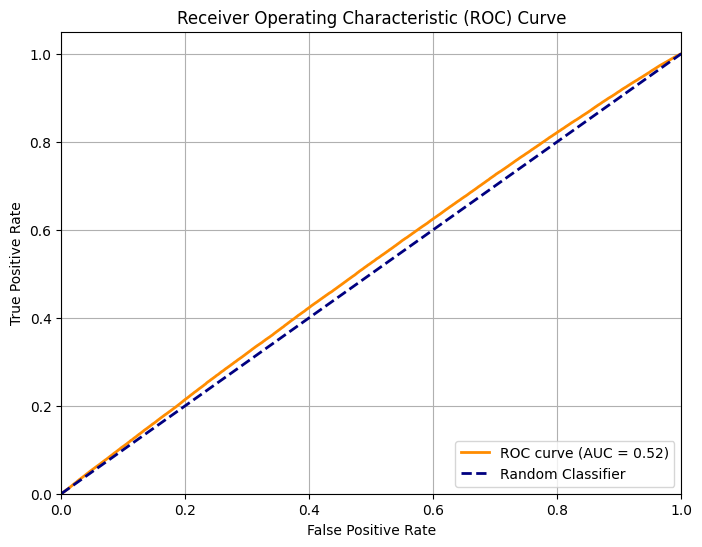

In [88]:
from sklearn.metrics import roc_curve, auc

#Get predicted probabilities for the positive class (class 1)
y_pred_proba = oof_proba[:, 1]

# 5. Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(X_TRAIN["Side"], y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 1.4 Fit Primary Model on complete Training Dataset

In [99]:
X_TRAIN.columns

Index(['Date', 'PERMNO', 'ma_5', 'ema_5', 'slope_ma_5', 'ma_10', 'ema_10',
       'slope_ma_10', 'ma_20', 'ema_20', 'slope_ma_20', 'ma_60', 'ema_60',
       'slope_ma_60', 'ret_1', 'ret_5', 'ret_10', 'ret_20', 'macd_dif',
       'macd_dea', 'macd', 'macd_cross', 'bb_mid', 'bb_upper', 'bb_lower',
       'bb_pctB', 'rsi', 'rsv_10', 'rsv_20', 'aroon_up_10', 'aroon_down_10',
       'aroon_up_20', 'aroon_down_20', 'range_hl_over_c', 'atr', 'gap_oc_prev',
       'gap_cc_prev', 'shadow_upper_ratio', 'shadow_lower_ratio', 'ret_c2c',
       'ret_co', 'ret_oc', 'vol', 'adv', 'dvol', 'vol_z', 'turnover_proxy',
       'vwap_proxy', 'pv_corr', 'pv_divergence', 'label', 'DlyClose',
       'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side',
       'pred_Side', 'pred_Side_proba'],
      dtype='object')

In [135]:
Drop = Label_cols + ["Date", "pred_Side" ,"pred_Side_proba"]

X_train_full_primary = X_TRAIN.drop(columns=Drop)
Y_train_full_primary = X_TRAIN["Side"].values

# Fit Primary Model on complete Training Data
primary_full = RandomForestClassifier(
        n_estimators   = 100,
        min_samples_leaf = 3,
        max_depth      = None,
        class_weight   = 'balanced',
        n_jobs         = -1,
        random_state   = 42,
    )

primary_full.fit(X_train_full_primary, Y_train_full_primary) 


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 1.5 Feature Importance

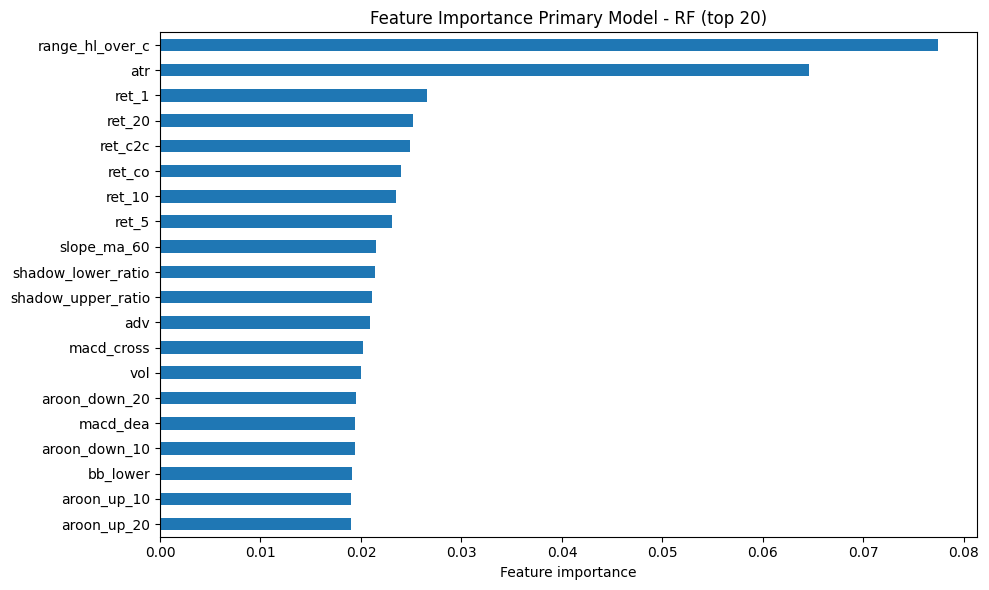

In [162]:
importances = primary.feature_importances_
feat_imp = pd.Series(importances, index=X_train_full_primary.columns).sort_values(ascending=False)
feat_imp_20 = feat_imp.head(20)

plt.figure(figsize=(10, 6))
feat_imp_20[::-1].plot(kind="barh")  # reverse to get largest at top
plt.xlabel("Feature importance")
plt.title(f"Feature Importance Primary Model - RF (top {20})")
plt.tight_layout()
plt.show()

# 2. Train Secondary Model on out-of-sample Side predictions - Random Forest

In [137]:
permno_list = X_TRAIN["PERMNO"].unique()

In [138]:
data_indexed = X_TRAIN.set_index(["Date", "PERMNO"], drop=False)
data_indexed = data_indexed.sort_index(level=0)

In [139]:
data_indexed.columns

Index(['Date', 'PERMNO', 'ma_5', 'ema_5', 'slope_ma_5', 'ma_10', 'ema_10',
       'slope_ma_10', 'ma_20', 'ema_20', 'slope_ma_20', 'ma_60', 'ema_60',
       'slope_ma_60', 'ret_1', 'ret_5', 'ret_10', 'ret_20', 'macd_dif',
       'macd_dea', 'macd', 'macd_cross', 'bb_mid', 'bb_upper', 'bb_lower',
       'bb_pctB', 'rsi', 'rsv_10', 'rsv_20', 'aroon_up_10', 'aroon_down_10',
       'aroon_up_20', 'aroon_down_20', 'range_hl_over_c', 'atr', 'gap_oc_prev',
       'gap_cc_prev', 'shadow_upper_ratio', 'shadow_lower_ratio', 'ret_c2c',
       'ret_co', 'ret_oc', 'vol', 'adv', 'dvol', 'vol_z', 'turnover_proxy',
       'vwap_proxy', 'pv_corr', 'pv_divergence', 'label', 'DlyClose',
       'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side',
       'pred_Side', 'pred_Side_proba'],
      dtype='object')

In [140]:
from Labeling import meta_labeling
# Based on the Out of Sample Prediction for the Training Data obtained using pruged CV,
# label the event [1,0] if profitable or not.
data_meta_dict = {}

for id in permno_list:
    
    data_sub = data_indexed.xs(id, level="PERMNO").sort_index()
    prices_sub = prices.xs(id, level="PERMNO").sort_index()

    labels = meta_labeling(data_sub, prices_sub["DlyClose"], threshold=0.4)
    
    labeled_events = pd.merge(data_sub, labels, left_index=True, right_index=True)
    data_meta_dict[id] = labeled_events

In [141]:
X_TRAIN = pd.concat(data_meta_dict, ignore_index=True)

In [142]:
X_TRAIN.columns

Index(['Date', 'PERMNO', 'ma_5', 'ema_5', 'slope_ma_5', 'ma_10', 'ema_10',
       'slope_ma_10', 'ma_20', 'ema_20', 'slope_ma_20', 'ma_60', 'ema_60',
       'slope_ma_60', 'ret_1', 'ret_5', 'ret_10', 'ret_20', 'macd_dif',
       'macd_dea', 'macd', 'macd_cross', 'bb_mid', 'bb_upper', 'bb_lower',
       'bb_pctB', 'rsi', 'rsv_10', 'rsv_20', 'aroon_up_10', 'aroon_down_10',
       'aroon_up_20', 'aroon_down_20', 'range_hl_over_c', 'atr', 'gap_oc_prev',
       'gap_cc_prev', 'shadow_upper_ratio', 'shadow_lower_ratio', 'ret_c2c',
       'ret_co', 'ret_oc', 'vol', 'adv', 'dvol', 'vol_z', 'turnover_proxy',
       'vwap_proxy', 'pv_corr', 'pv_divergence', 'label', 'DlyClose',
       'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side',
       'pred_Side', 'pred_Side_proba', 'Return of Label', 'Label'],
      dtype='object')

In [143]:
X_TRAIN["Label"].value_counts()

Label
0.0    194429
1.0     48968
Name: count, dtype: int64

In [144]:
#include predicted Side and Probabilities in Meta Model
Drop = Label_cols + ["Date", "Return of Label", "Label"]
X_meta = X_TRAIN.drop(columns=Drop)

Y_meta = X_TRAIN["Label"].values

In [145]:
#Fit the Meta Model on the Training Set.
secondary  = RandomForestClassifier(
    n_estimators   = 100,
    min_samples_leaf = 5,
    max_depth      = None,
    class_weight   = 'balanced',
    n_jobs         = -1,
    random_state   = 42,
)

secondary.fit(X_meta, Y_meta)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# 3. Prediction on Held Out Test Set

In [146]:
X_TEST.columns

Index(['Date', 'PERMNO', 'ma_5', 'ema_5', 'slope_ma_5', 'ma_10', 'ema_10',
       'slope_ma_10', 'ma_20', 'ema_20', 'slope_ma_20', 'ma_60', 'ema_60',
       'slope_ma_60', 'ret_1', 'ret_5', 'ret_10', 'ret_20', 'macd_dif',
       'macd_dea', 'macd', 'macd_cross', 'bb_mid', 'bb_upper', 'bb_lower',
       'bb_pctB', 'rsi', 'rsv_10', 'rsv_20', 'aroon_up_10', 'aroon_down_10',
       'aroon_up_20', 'aroon_down_20', 'range_hl_over_c', 'atr', 'gap_oc_prev',
       'gap_cc_prev', 'shadow_upper_ratio', 'shadow_lower_ratio', 'ret_c2c',
       'ret_co', 'ret_oc', 'vol', 'adv', 'dvol', 'vol_z', 'turnover_proxy',
       'vwap_proxy', 'pv_corr', 'pv_divergence', 'label', 'DlyClose',
       'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side'],
      dtype='object')

In [147]:
Drop = Label_cols + ["Date"]

X_test = X_TEST.drop(columns=Drop)
Y_train = X_TEST["Side"].values

In [148]:
# Primary predictions on held-out test
side_proba= primary_full.predict_proba(X_test)
side_pred = primary_full.predict(X_test)

In [149]:
X_test.loc[: , "pred_Side"] = side_pred
X_test.loc[: , "pred_Side_proba"] = np.max(side_proba, axis=1)

X_TEST.loc[: , "pred_Side"] = side_pred
X_TEST.loc[: , "pred_Side_proba"] = np.max(side_proba, axis=1)

In [150]:
label = secondary.predict(X_test)
label_prob = np.max(secondary.predict_proba(X_test) , axis = 1) 

In [151]:
X_TEST.loc[: , "pred_Label"] = label
X_TEST.loc[: , "pred_Label_proba"] = label_prob
X_TEST

,Date,PERMNO,ma_5,ema_5,slope_ma_5,ma_10,ema_10,slope_ma_10,ma_20,ema_20,...,timestamp,End Time,Return,trade_days,Return_dly,Side,pred_Side,pred_Side_proba,pred_Label,pred_Label_proba
258249,2017-04-03,84373,1.028798,1.029152,-0.734073,1.036952,1.030845,-0.426289,1.030417,1.025454,...,2017-04-03,2017-04-13,-0.007754,9,-0.000862,0.0,0.0,0.774383,0.0,1.000000
258250,2017-04-03,12566,-0.629218,-0.629277,-0.147353,-0.629495,-0.629568,0.280742,-0.629844,-0.630186,...,2017-04-03,2017-04-11,0.024359,7,0.003480,1.0,0.0,0.436033,0.0,0.925657
258251,2017-04-03,86372,0.012773,0.011577,0.210774,0.008593,0.009151,0.081046,0.004195,0.007122,...,2017-04-03,2017-04-13,-0.018143,9,-0.002016,0.0,0.0,0.509652,0.0,1.000000
258252,2017-04-03,79499,-0.902717,-0.903031,-0.406424,-0.900717,-0.901670,0.199784,-0.899370,-0.901501,...,2017-04-03,2017-04-06,0.051282,4,0.012821,1.0,1.0,0.590341,1.0,0.675976
258253,2017-04-03,77120,-0.133451,-0.133443,0.203154,-0.136038,-0.132001,-0.070075,-0.124098,-0.125416,...,2017-04-03,2017-04-10,-0.056110,6,-0.009352,-1.0,0.0,0.429283,0.0,0.947593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432907,2019-12-31,85604,0.143098,0.144323,0.875015,0.140216,0.143409,0.822942,0.145994,0.151934,...,2019-12-31,2020-01-02,-0.024066,2,-0.012033,-1.0,-1.0,0.341240,0.0,0.908369
432908,2019-12-31,92619,-0.779753,-0.779340,0.108539,-0.780041,-0.779734,-0.138136,-0.779839,-0.779817,...,2019-12-31,2020-01-07,0.046512,5,0.009302,1.0,1.0,0.479521,1.0,0.517144
432909,2019-12-31,92596,-0.460334,-0.462235,-0.653146,-0.463506,-0.463317,0.023678,-0.467173,-0.464310,...,2019-12-31,2020-01-06,0.016234,4,0.004058,0.0,1.0,0.432984,1.0,0.673071
432910,2019-12-31,86369,-0.710898,-0.710502,0.051054,-0.710958,-0.710649,-0.123426,-0.710131,-0.710236,...,2019-12-31,2020-01-03,-0.006240,3,-0.002080,0.0,0.0,0.802724,0.0,1.000000


In [152]:
X_TEST["pred_Side"].value_counts()

pred_Side
 0.0    88601
 1.0    49211
-1.0    36851
Name: count, dtype: int64

In [153]:
with open('./Data/scores_test_side_meta_labeled_rf.pkl', 'wb') as file:
    pkl.dump(X_TEST, file)

# Backtesting the Strategy


We now have all predictions on the Test set
Recap: Meta_Label is set based on a minimal profit of 2% at event endtime, so model should try to learn/focus on events with actual return.

Test the following Strategy: 
- Leverage the Label Probability to determine Trades to take and compute return of that strategy.


In [163]:
with open('./Data/scores_test_side_meta_labeled_rf.pkl', 'rb') as file:
    X_backtest = pkl.load(file)

In [164]:
def return_of_Label(
    events: pd.DataFrame,
    Label_prob = 0.7,
) -> pd.DataFrame:

    events_filtered = events.dropna(subset=['End Time'])
    out = pd.DataFrame(index=events_filtered.index)

    out["Date"] = events_filtered["Date"]
    #Return of Label = positive if sign of return equal predicted Side and vice versa
    out['Return of Label'] = events_filtered["Return"] * events_filtered['pred_Side']

    #return of each event
    out["event_ret"] = out['Return of Label'] * events_filtered['pred_Label']

    #If Probability to Trade less then threshold set value to zero --> No Trade
    out.loc[(events_filtered["pred_Label_proba"] <= Label_prob), "event_ret"] = 0
    
    out["event_ret_dly"] = out["event_ret"] / events_filtered["trade_days"]

    return out

In [166]:
df_results

,Date,Return of Label,event_ret,event_ret_dly
258249,2017-04-03,-0.000000,-0.0,-0.0
258250,2017-04-03,0.000000,0.0,0.0
258251,2017-04-03,-0.000000,-0.0,-0.0
258252,2017-04-03,0.051282,0.0,0.0
258253,2017-04-03,-0.000000,-0.0,-0.0
...,...,...,...,...
432907,2019-12-31,0.024066,0.0,0.0
432908,2019-12-31,0.046512,0.0,0.0
432909,2019-12-31,0.016234,0.0,0.0
432910,2019-12-31,-0.000000,-0.0,-0.0


In [167]:
# Basic stats
df_backtest = df_results[df_results["event_ret"] != 0]

In [168]:
# Basic stats
mean_ret_daily = df_backtest["event_ret_dly"].mean()
mean_ret = df_backtest["event_ret"].mean()

event_std_ret  = df_backtest["event_ret"].std()
std_ret_daily = df_backtest["event_ret_dly"].std()

n_trades = df_backtest.shape[0]

# Annualized Sharpe (assuming event frequency ~ daily)
sharpe = mean_ret_daily / std_ret_daily * np.sqrt(252) if std_ret_daily > 0 else np.nan

print(f"Out-of-sample trades: {n_trades}, Total number of Out-of_sample events: {df_results.shape[0]}")
print(f"Mean event return: {mean_ret:.6f}")
print(f"Mean daily event return: {mean_ret_daily:.6f}")
print(f"Std event return:  {std_ret_daily:.6f}")
print(f"Annualized Sharpe: {sharpe:.3f}")


Out-of-sample trades: 6508, Total number of Out-of_sample events: 174663
Mean event return: 0.000038
Mean daily event return: 0.000196
Std event return:  0.022260
Annualized Sharpe: 0.140


In [160]:
daily_ret = (
    df_backtest
    .groupby("Date")["event_ret_dly"]
    .mean()
    .sort_index()
)

# 累计收益曲线（简单收益）
equity_curve = (1 + daily_ret).cumprod()

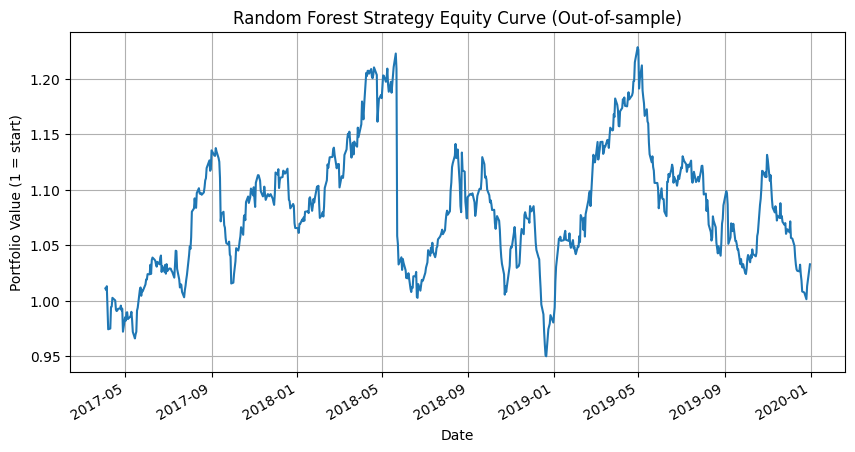

In [161]:
plt.figure(figsize=(10, 5))
equity_curve.plot()
plt.title("Random Forest Strategy Equity Curve (Out-of-sample)")
plt.ylabel("Portfolio Value (1 = start)")
plt.xlabel("Date")
plt.grid(True)
plt.show()